In [1]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.792s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.066s


In [6]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 9.927s
Best estimator found by grid search:
SVC(C=81389.08626055092, class_weight='balanced', gamma=0.002770034825194885)


Predicting people's names on the test set
done in 0.221s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.75      0.88      0.81        60
  Donald Rumsfeld       0.75      0.67      0.71        27
    George W Bush       0.91      0.93      0.92       146
Gerhard Schroeder       0.87      0.80      0.83        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.94      0.81      0.87        36

         accuracy                           0.85       322
        macro avg       0.82      0.77      0.79       322
     weighted avg       0.86      0.85      0.85       322



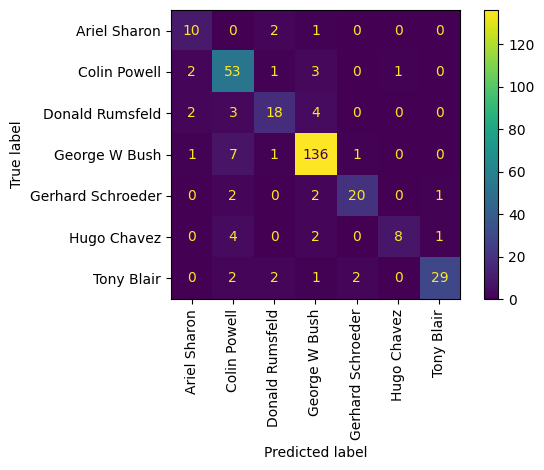

In [7]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

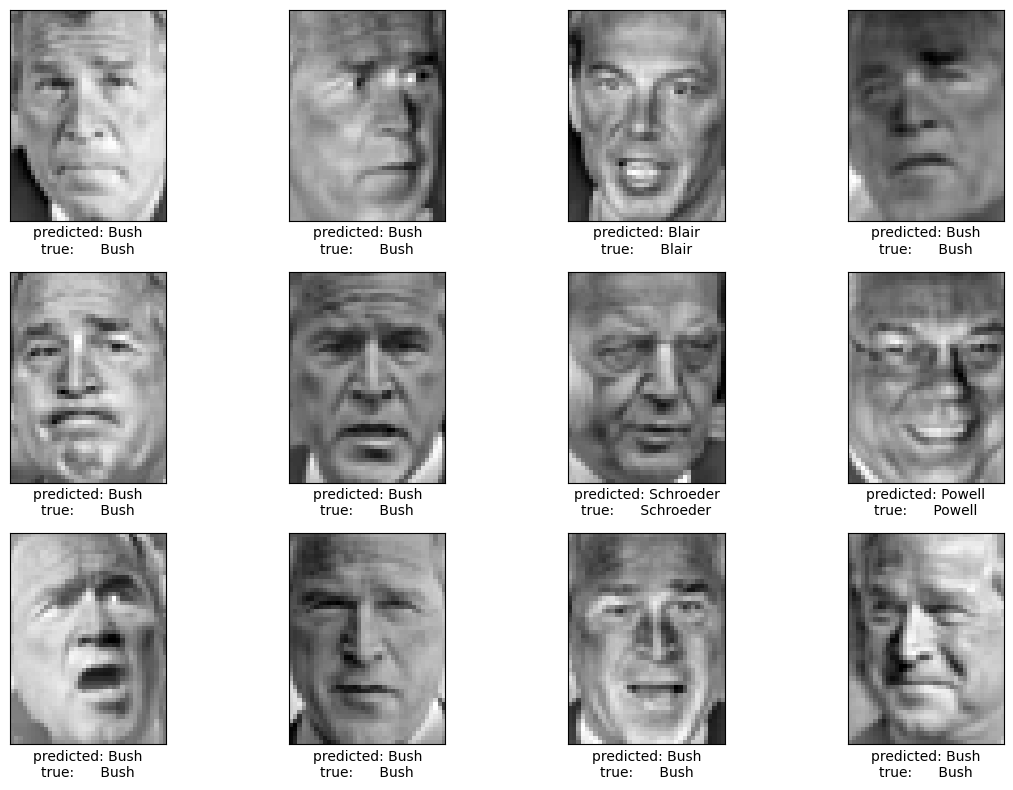

In [12]:
#plot the result of the prediction on a portion of the test set
import matplotlib.pyplot as plt

def plot_result(X, y_pred, y_test, target_names, rows=3, columns=4):
    fig, axes = plt.subplots(rows, columns, figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].reshape(h, w), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(title(y_pred, y_test, target_names, i))
    plt.tight_layout()
    plt.show()

# Assuming you have defined the `target_names`, `y_pred`, `y_test`, `X_test`, `h`, and `w` variables

plot_result(X_test, y_pred, y_test, target_names)


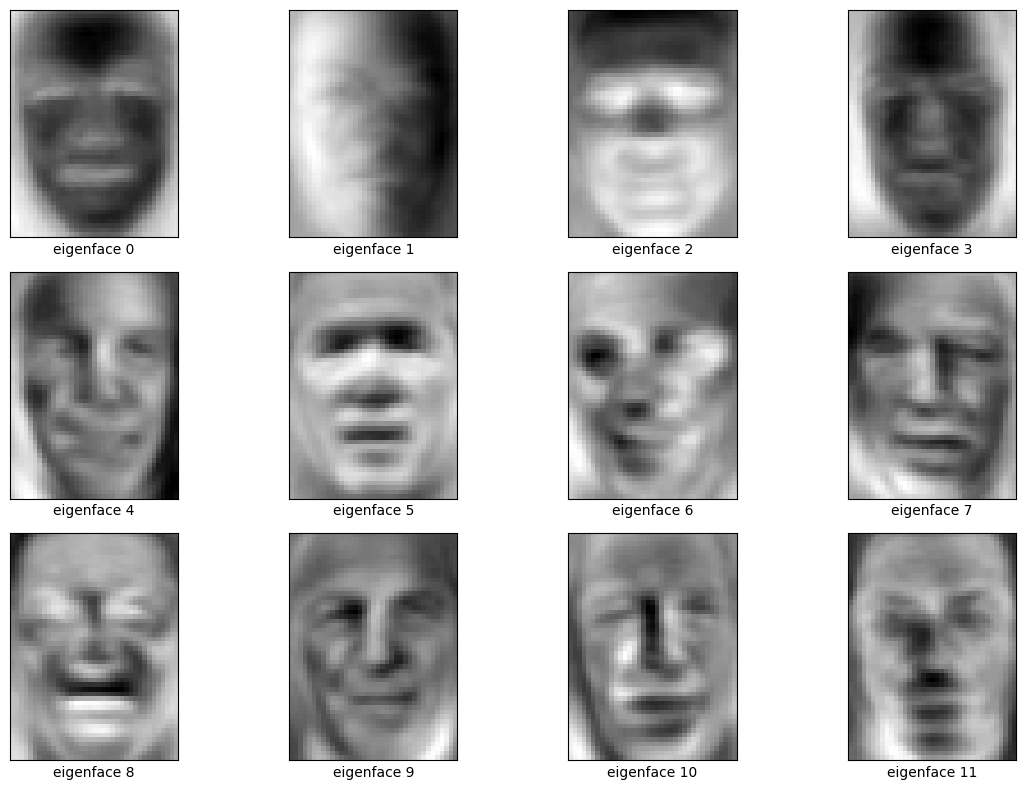

In [16]:

import matplotlib.pyplot as plt

def plot_gallery(images, titles, h, w, rows=3, columns=4):
    fig, axes = plt.subplots(rows, columns, figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(h, w), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(titles[i])
    plt.tight_layout()
    plt.show()

# Assuming you have defined the `eigenfaces`, `h`, and `w` variables

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
